In [2]:
# ── Imports ──────────────────────────────────────────────────────────────────
# pandas        – data manipulation, pivot tables, CSV I/O
# requests      – HTTP calls to the Frankfurter exchange-rate API
# Decimal       – banker's rounding (ROUND_HALF_UP) for tax-precision arithmetic
# matplotlib    – static charts (bar, pie)
# seaborn       – plot styling / aesthetics
# PercentFormatter – optional y-axis formatter for percentage scales
# scipy.stats   – one-way ANOVA (f_oneway) for hypothesis testing

import pandas as pd 
import requests
from decimal import Decimal, ROUND_HALF_UP
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()  # apply seaborn default theme to all subsequent plots
from matplotlib.ticker import PercentFormatter 
from scipy import stats

In [3]:
# ── 1. Data ingestion ────────────────────────────────────────────────────────
# Load the raw Q1 2025 sales/VAT dataset from a comma-delimited CSV.
# We immediately create a working copy (`df`) so the original `data`
# stays untouched – useful if we ever need to reset or compare.

data = pd.read_csv('1Q_VAT.csv', delimiter = ',')
df = data.copy()
df.head()  # quick sanity check – first 5 rows

,transaction_ID,purchaser,amount_without_VAT,currency,rate_VAT,date
0,1,Company E,6227.56,EUR,0.21,3/12/2025
1,2,Company D,3876.45,EUR,0.21,3/23/2025
2,3,Company D,6476.58,EUR,0.21,2/23/2025
3,4,Company B,8198.67,GBP,0.21,1/25/2025
4,5,Company A,7971.64,CZK,0.21,3/6/2025


In [4]:
# ── 2. Checkpoint helper ─────────────────────────────────────────────────────
# Saves the current DataFrame to CSV and immediately re-reads it.
# This serves two purposes:
#   a) creates a persistent backup of the intermediate state on disk,
#   b) round-trips through CSV so that subsequent work starts from the
#      exact same serialized representation (avoids floating-point drift
#      between in-memory Decimal objects and what CSV stores).

def checkpoint(file_name, checkpoint_data):
    checkpoint_data.to_csv(file_name + '.csv', index=False)
    return pd.read_csv(file_name + '.csv')

In [5]:
# ── 3. Display settings ──────────────────────────────────────────────────────
# Remove pandas' default column / row truncation so that every column and
# every row is visible when printing DataFrames in this notebook.

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [6]:
# ── 4. Initial schema inspection ─────────────────────────────────────────────
# Print column names, non-null counts and data types.
# Key observations:
#   • 1 000 rows total, but `amount_without_VAT` has only 898 non-nulls
#     → 102 NaN rows (stornos / entry errors / unearned revenue).
#   • `date` is still a plain object (string) – will be converted later.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_ID      1000 non-null   int64  
 1   purchaser           1000 non-null   object 
 2   amount_without_VAT  898 non-null    float64
 3   currency            1000 non-null   object 
 4   rate_VAT            1000 non-null   float64
 5   date                1000 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 47.0+ KB


In [7]:
# ── 5. Data cleaning ─────────────────────────────────────────────────────────
# 1) Drop rows where the net amount is NaN.
#    These represent stornos, entry errors, or unearned revenue –
#    they carry no monetary value and would distort aggregations.
# 2) Remove `transaction_ID` – it is just a sequential counter with no
#    analytical value and could confuse numeric aggregations.
# 3) Rename the amount column for brevity used throughout the notebook.

df = df.dropna(subset='amount_without_VAT')       # 1 000 → 898 rows
df = df.drop('transaction_ID', axis=1)             # drop surrogate key
df = df.rename(columns={'amount_without_VAT': 'amount_wo_VAT'})
df.info()  # confirm: 898 rows × 5 columns, zero nulls

<class 'pandas.core.frame.DataFrame'>
Index: 898 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   purchaser      898 non-null    object 
 1   amount_wo_VAT  898 non-null    float64
 2   currency       898 non-null    object 
 3   rate_VAT       898 non-null    float64
 4   date           898 non-null    object 
dtypes: float64(2), object(3)
memory usage: 42.1+ KB


In [8]:
# ── 6. Date preparation ──────────────────────────────────────────────────────
# • Parse the string dates (M/D/YYYY format, so dayfirst=False) into
#   proper datetime objects.  `errors='coerce'` turns unparseable values
#   into NaT so they don't crash the pipeline.
# • Extract the month number (1-3) into its own column – needed for
#   Month-over-Month aggregations and the ANOVA test later.
# • Convert back to `datetime.date` (drop the time component) so the
#   Frankfurter API receives clean YYYY-MM-DD strings.

df['date'] = pd.to_datetime(df['date'], dayfirst=False, errors='coerce')
df['month_no'] = df['date'].dt.month   # 1 = Jan, 2 = Feb, 3 = Mar
df['date'] = df['date'].dt.date        # datetime → date (no time part)
df.head()

,purchaser,amount_wo_VAT,currency,rate_VAT,date,month_no
0,Company E,6227.56,EUR,0.21,2025-03-12,3
1,Company D,3876.45,EUR,0.21,2025-03-23,3
2,Company D,6476.58,EUR,0.21,2025-02-23,2
3,Company B,8198.67,GBP,0.21,2025-01-25,1
4,Company A,7971.64,CZK,0.21,2025-03-06,3


In [9]:
# ── 7. Currency conversion to EUR via Frankfurter API ────────────────────────
# Strategy: instead of calling the API once per row (898 calls), we first
# collect the unique (date, currency) pairs that are NOT already in EUR.
# This dramatically reduces the number of HTTP requests (batch approach).

unique_rates = df[['date', 'currency']].drop_duplicates()
unique_rates = unique_rates[unique_rates['currency'] != 'EUR']  # EUR→EUR = 1.0

def fetch_eur_rate(row):
    """Call the Frankfurter API for a single (date, currency) pair
    and return the EUR exchange rate. Returns None on any error
    so that the pipeline does not crash on transient network issues."""
    date_str = row['date'].strftime('%Y-%m-%d')
    base = row['currency']
    url = f"https://api.frankfurter.app/{date_str}?from={base}&to=EUR"
    try:
        response = requests.get(url)
        data = response.json()
        return data['rates']['EUR']
    except Exception:
        return None

# Fetch the rate for every unique (date, currency) pair
unique_rates['rate_to_eur'] = unique_rates.apply(fetch_eur_rate, axis=1)

# Left-join the rates back onto the main DataFrame.
# Rows that are already in EUR will have NaN for rate_to_eur after
# the merge, so we fill those with 1.0 (identity conversion).
df = df.merge(unique_rates, on=['date', 'currency'], how='left')
df.loc[df['currency'] == 'EUR', 'rate_to_eur'] = 1.0

# Compute the EUR-equivalent net amount for every transaction
df['amount_wo_VAT_EUR'] = df['amount_wo_VAT'] * df['rate_to_eur']
df.head()

,purchaser,amount_wo_VAT,currency,rate_VAT,date,month_no,rate_to_eur,amount_wo_VAT_EUR
0,Company E,6227.56,EUR,0.21,2025-03-12,3,1.00000,6227.560000
1,Company D,3876.45,EUR,0.21,2025-03-23,3,1.00000,3876.450000
2,Company D,6476.58,EUR,0.21,2025-02-23,2,1.00000,6476.580000
3,Company B,8198.67,GBP,0.21,2025-01-25,1,1.18470,9712.964349
4,Company A,7971.64,CZK,0.21,2025-03-06,3,0.03992,318.227869


In [18]:
# ── 8. Banker's rounding & VAT calculation ───────────────────────────────────
# Tax authorities typically require ROUND_HALF_UP ("banker's rounding")
# instead of Python's default "round half to even".  We use the `decimal`
# module so rounding is deterministic to 3 decimal places (0.001 EUR).
#
# Steps:
#   a) Round the EUR net amount to 3 d.p.
#   b) Round the VAT rate to 3 d.p. (ensures e.g. 0.210 not 0.20999…)
#   c) Compute VAT = rate × net amount, then round the result as well.
# NOTE: after this cell the monetary columns are Decimal objects (stored
# as `object` dtype in pandas).  They will be cast back to float before
# the visualisation step.

def tax_round(x):
    """Round a numeric value to 3 decimal places using ROUND_HALF_UP."""
    return Decimal(str(x)).quantize(Decimal('0.001'), rounding=ROUND_HALF_UP)

df['amount_wo_VAT_EUR'] = df['amount_wo_VAT_EUR'].apply(tax_round)
df['rate_VAT'] = df['rate_VAT'].apply(tax_round)
df['amount_VAT_EUR'] = df['rate_VAT'] * df['amount_wo_VAT_EUR']
df['amount_VAT_EUR'] = df['amount_VAT_EUR'].apply(tax_round)
df.info()  # monetary cols are now object (Decimal) – expected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   purchaser          898 non-null    object 
 1   amount_wo_VAT      898 non-null    float64
 2   currency           898 non-null    object 
 3   rate_VAT           898 non-null    object 
 4   date               898 non-null    object 
 5   month_no           898 non-null    int32  
 6   rate_to_eur        898 non-null    float64
 7   amount_wo_VAT_EUR  898 non-null    object 
 8   amount_VAT_EUR     898 non-null    object 
dtypes: float64(2), int32(1), object(6)
memory usage: 59.8+ KB


In [20]:
# ── 9. Save checkpoint ───────────────────────────────────────────────────────
# Persist the cleaned, EUR-converted dataset to Data_in_EUR.csv.
# On subsequent runs you can skip the API calls by loading this file instead.

checkpoint_1 = checkpoint('Data_in_EUR', df)

In [21]:
# ── 10. Duplicate detection ──────────────────────────────────────────────────
# Two transactions are considered duplicates when they share the same
# net amount, currency, date AND purchaser.  Duplicates would inflate
# monthly revenue totals, so we flag them here.
# If any are found the notebook prints an alert with the offending rows.

is_duplicate = df.duplicated(subset=['amount_wo_VAT', 'currency', 'date', 'purchaser'])
duplicate_rows = df[is_duplicate]

if len(duplicate_rows) > 0:
    print(f"\nALERT: Found {len(duplicate_rows)} duplicate values")
    print(duplicate_rows[['date', 'currency', 'amount_wo_VAT_EUR', 'amount_VAT_EUR']])
else:
    print("No duplicate rows detected. ")

No duplicate rows detected. 


In [48]:
# ── 11. VAT rate compliance check ────────────────────────────────────────────
# Legal VAT categories are 21 %, 9 % and 0 % (tax-exempt).
# Any transaction carrying a rate outside this set is a potential
# compliance risk and should be investigated.

unique_rates = sorted(df['rate_VAT'].unique())

# Pretty-print the rates found in the data
formatted_rates = [f"{rate * 100:.0f} %" for rate in unique_rates]
print(f"Unique VAT rates found in your data: {', '.join(formatted_rates)}")

# Flag rows whose rate (converted to %) is NOT in the allowed set
expected_rates = [21, 9, 0]
anomalies = df[~(df['rate_VAT'] * 100).isin(expected_rates)]

if len(anomalies) > 0:
    print(f"\nFound {len(anomalies)} transactions with unexpected VAT rates!")
    print(anomalies[['date', 'currency', 'amount_wo_VAT_EUR', 'amount_VAT_EUR', 'rate_VAT']])
else:
    print("All VAT rates match the legal categories – no compliance issues.")

Unique VAT rates found in your data: 0 %, 9 %, 21 %
Found non-compliance rates.


In [22]:
# ── 12. Pivot table – VAT tax base ───────────────────────────────────────────
# Aggregate the EUR net amounts (tax base) broken down by:
#   rows    = month (January / February / March)
#   columns = VAT rate (0 % / 9 % / 21 %)
# `margins=True` adds a "Total" row and column automatically.
# The result is saved to VAT_TAX_base_data.csv and rendered with
# a styled HTML table (bold totals, centred text, borders).

pivot_df = pd.pivot_table(df, 
                          values='amount_wo_VAT_EUR', 
                          index='month_no', 
                          columns='rate_VAT', 
                          aggfunc='sum', 
                          margins=True, 
                          margins_name='Total').fillna(0)

month_map = {1: 'January', 2: 'February', 3: 'March', 'Total': 'Total'}
month_names = [month_map.get(m, m) for m in pivot_df.index]

vat_cols = []
for col in pivot_df.columns:
    if col == 'Total':
        vat_cols.append('Total')
    else:
        vat_cols.append(f"{col * 100:.0f}%")

pivot_df.columns = pd.MultiIndex.from_product([['VAT rate'], vat_cols])
pivot_df.index = pd.MultiIndex.from_product([['Months'], month_names])

def style_totals(df_data):
    style_df = pd.DataFrame('', index=df_data.index, columns=df_data.columns)
    is_total_row = df_data.index.get_level_values(1) == 'Total'
    is_total_col = df_data.columns.get_level_values(1) == 'Total'
    
    style_df.loc[is_total_row, :] = 'font-weight: bold'
    style_df.loc[:, is_total_col] = 'font-weight: bold'
    return style_df

final_design = pivot_df.style.format("{:,.0f}")\
    .apply(style_totals, axis=None)\
    .set_properties(**{
        'text-align': 'center',
        'border': '1px solid black',
        'padding': '8px',
        'background-color': 'white'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('border', '1px solid black'),
            ('background-color', '#f2f2f2'),
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('vertical-align', 'middle')
        ]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse')]}
    ])
pivot_df.to_csv("VAT_TAX_base_data.csv")
final_design

In [23]:
# ── 13. Pivot table – VAT tax liability ──────────────────────────────────────
# Same structure as the tax-base pivot, but now aggregating the computed
# VAT amounts (amount_VAT_EUR) instead of net amounts.
# Tax-exempt transactions (0 % VAT) produce zero liability, so we drop
# that column for cleaner reporting.
# Result is saved to VAT_TAX_liability.csv.

pivot_df = pd.pivot_table(df, 
                          values='amount_VAT_EUR', 
                          index='month_no', 
                          columns='rate_VAT', 
                          aggfunc='sum', 
                          margins=True, 
                          margins_name='Total').fillna(0)

# Drop the 0 % column – zero-rated transactions carry no liability
if 0.0 in pivot_df.columns:
    pivot_df = pivot_df.drop(columns=[0.0])


month_map = {1: 'January', 2: 'February', 3: 'March', 'Total': 'Total'}
month_names = [month_map.get(m, m) for m in pivot_df.index]


vat_cols = []
for col in pivot_df.columns:
    if col == 'Total':
        vat_cols.append('Total')
    else:
        vat_cols.append(f"{col * 100:.0f}%")

pivot_df.columns = pd.MultiIndex.from_product([['VAT rate'], vat_cols])
pivot_df.index = pd.MultiIndex.from_product([['Months'], month_names])
def style_totals(df_data):
    style_df = pd.DataFrame('', index=df_data.index, columns=df_data.columns)
    is_total_row = df_data.index.get_level_values(1) == 'Total'
    is_total_col = df_data.columns.get_level_values(1) == 'Total'

    
    style_df.loc[is_total_row, :] = 'font-weight: bold'
    style_df.loc[:, is_total_col] = 'font-weight: bold'
    return style_df
final_design = pivot_df.style.format("{:,.0f}")\
    .apply(style_totals, axis=None)\
    .set_properties(**{
        'text-align': 'center',
        'border': '1px solid black',
        'padding': '8px',
        'background-color': 'white'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('border', '1px solid black'),
            ('background-color', '#f2f2f2'),
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('vertical-align', 'middle')
        ]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse')]}
    ])
pivot_df.to_csv("VAT_TAX_liability.csv")
final_design


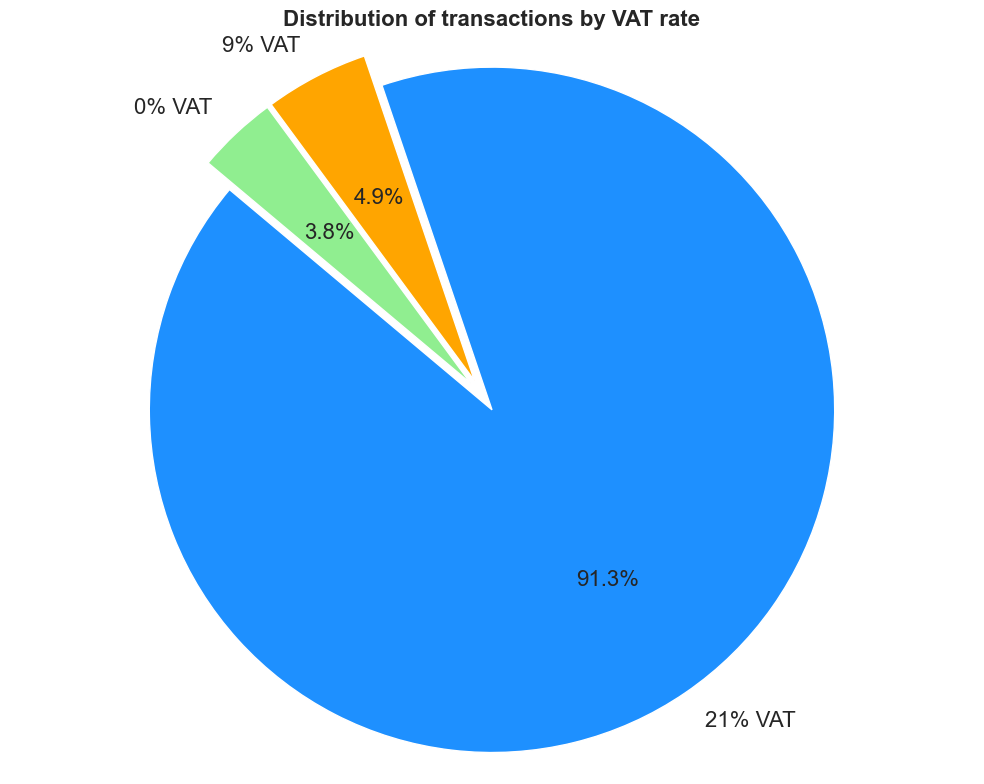

In [49]:
# ── 14. Pie chart – VAT rate distribution ────────────────────────────────────
# Shows the proportion of transactions in each VAT category (0 %, 9 %, 21 %).
# This gives a quick visual sense of how the transaction mix is composed.
# A slight "explode" offset separates the slices for readability.

vat_counts = df['rate_VAT'].value_counts()  # count of rows per rate
labels = [f"{float(rate)*100:.0f}% VAT" for rate in vat_counts.index]

colors = ['dodgerblue', 'orange', 'lightgreen']

plt.figure(figsize=(10, 8))
plt.pie(
    vat_counts, 
    labels=labels, 
    autopct='%1.1f%%',          # show percentage inside each slice
    startangle=140, 
    colors=colors,
    explode=[0.05] * len(vat_counts),  # slight separation between slices
    textprops={'fontsize': 16}
)
plt.title('Distribution of transactions by VAT rate', fontsize=16, fontweight='bold')
plt.axis('equal')  # ensure the pie is a perfect circle

plt.tight_layout()
plt.savefig('VAT_Distribution_Pie.png', dpi=80)
plt.show()

In [50]:
# ── 15. Type casting for visualisation ───────────────────────────────────────
# After the banker's rounding step the monetary columns contain Python
# Decimal objects (stored as pandas `object` dtype).  Matplotlib and
# seaborn require plain numeric types, so we cast them back to float64.
# `errors='coerce'` converts any remaining non-numeric values to NaN.

df['amount_wo_VAT_EUR'] = pd.to_numeric(df['amount_wo_VAT_EUR'], errors='coerce')
df['amount_VAT_EUR'] = pd.to_numeric(df['amount_VAT_EUR'], errors='coerce')

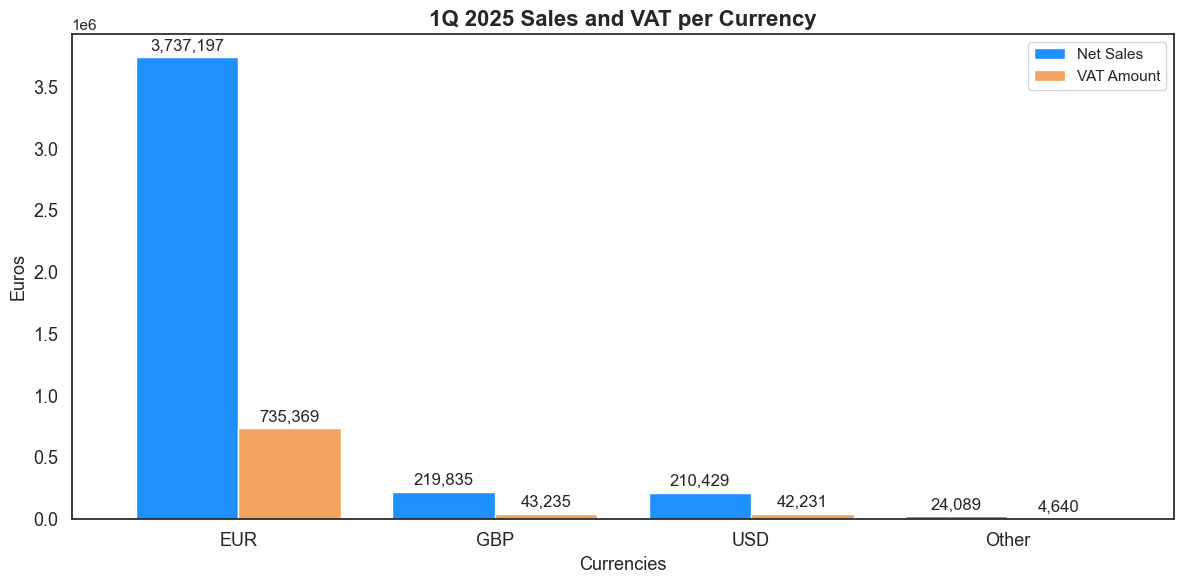

In [59]:
# ── 16. Bar chart – Sales & VAT by currency ──────────────────────────────────
# Shows net sales and VAT amounts side-by-side for each original currency,
# all converted to EUR.  Currencies contributing < 1 % of total sales
# are collapsed into an "Other" bucket to keep the chart readable.

df_grouped = df.groupby('currency')[['amount_wo_VAT_EUR', 'amount_VAT_EUR']].sum().reset_index()

# Dimensional reduction: collapse tiny currencies into "Other"
threshold = df_grouped['amount_wo_VAT_EUR'].sum() * 0.01
df_grouped['display_currency'] = df_grouped.apply(
    lambda x: x['currency'] if x['amount_wo_VAT_EUR'] >= threshold else 'Other', 
    axis=1
)
df_final = df_grouped.groupby('display_currency')[['amount_wo_VAT_EUR', 'amount_VAT_EUR']].sum()
df_final = df_final.sort_values('amount_wo_VAT_EUR', ascending=False)

# Plot grouped bar chart
sns.set_style('white')
ax = df_final.plot(kind='bar', figsize=(12, 6),
                   color=['dodgerblue', 'sandybrown'], width=0.8)
ax.legend(['Net Sales', 'VAT Amount'], loc='upper right')

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, padding=3, fmt='{:,.0f}')

plt.xticks(rotation=0, fontsize=13)
plt.yticks(fontsize=13)
plt.title('1Q 2025 Sales and VAT per Currency', fontsize=16, fontweight='bold')
plt.ylabel('Euros', fontsize=13)
plt.xlabel('Currencies', fontsize=13)
plt.tight_layout()
plt.savefig('1Q2025_Sales_VAT_Currency.png', dpi=100)
plt.show()

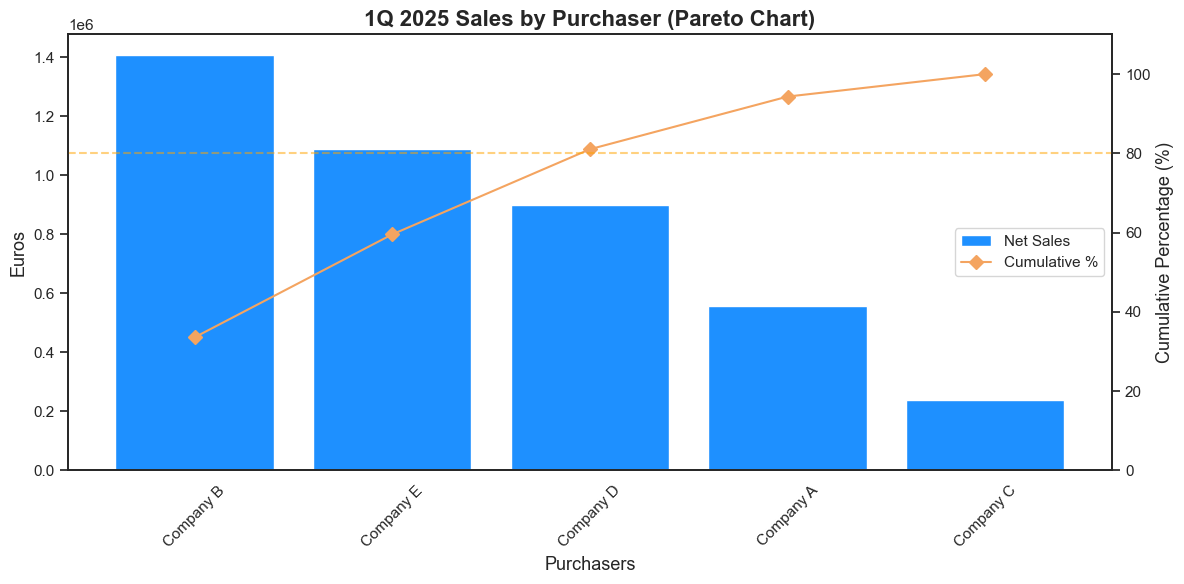

In [60]:
# ── 17. Pareto chart – Sales by purchaser ────────────────────────────────────
# Aggregates net EUR sales per purchaser, sorted descending, then overlays
# a cumulative-percentage line.  The dashed 80 % line highlights the
# classic Pareto threshold (which purchasers account for 80 % of revenue).

df_final = df.groupby('purchaser')[['amount_wo_VAT_EUR']].sum()
df_final = df_final.sort_values('amount_wo_VAT_EUR', ascending=False)

# Cumulative % of total sales
df_final['cum_pct'] = (
    df_final['amount_wo_VAT_EUR'].cumsum() / df_final['amount_wo_VAT_EUR'].sum() * 100
)

sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis – bar chart of absolute sales
ax1.bar(df_final.index, df_final['amount_wo_VAT_EUR'],
        color='dodgerblue', width=0.8, label='Net Sales')
ax1.set_ylabel('Euros', fontsize=13)
ax1.set_xlabel('Purchasers', fontsize=13)

# Secondary axis – cumulative line
ax2 = ax1.twinx()
ax2.plot(df_final.index, df_final['cum_pct'],
         color='sandybrown', marker='D', ms=7, label='Cumulative %')
ax2.axhline(80, color='orange', linestyle='--', alpha=0.5)  # 80 % Pareto line
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=13)
ax2.set_ylim(0, 110)

ax1.tick_params(axis='x', rotation=45, labelsize=11)
plt.title('1Q 2025 Sales by Purchaser (Pareto Chart)', fontsize=16, fontweight='bold')

# Merge legends from both axes into a single box
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

plt.tight_layout()
plt.savefig('1Q2025_Sales_Purchasers.png', dpi=100)
plt.show()

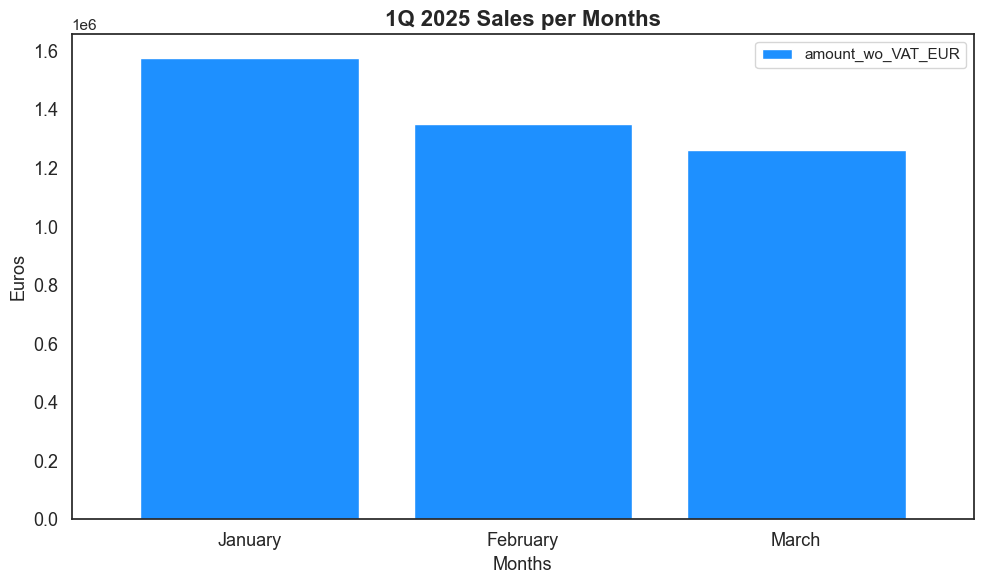

In [61]:
df_final = df.groupby('month_no')[['amount_wo_VAT_EUR']].sum()
df_final = df_final.sort_values('amount_wo_VAT_EUR', ascending=False)

sns.set_style('white')
ax = df_final.plot(kind='bar', 
                     figsize=(10, 6), 
                     color=['dodgerblue', 'sandybrown'],
                     width=0.8)
labels = ['January', 'February', 'March']
plt.xticks(ticks=range(len(labels)),labels = labels,rotation=0, fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('1Q 2025 Sales per Months', fontsize = 16, fontweight = 'bold')
plt.ylabel('Euros', fontsize = 13)
plt.xlabel( 'Months', fontsize = 13)
plt.tight_layout() 
plt.savefig('1Q2025_monthly_sales.png', dpi = 80) 
plt.show()

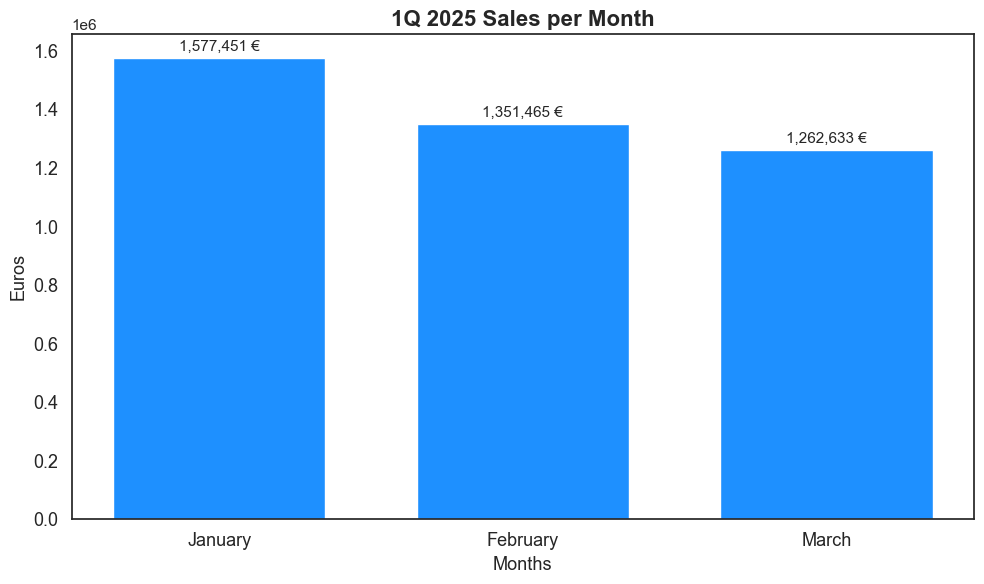

In [66]:
# ── 19. Bar chart – Month-over-Month sales trend ────────────────────────────
# Aggregates total EUR net sales for each month (Jan / Feb / Mar) and
# plots them as a bar chart with value labels in EUR on top of each bar.
# Useful for spotting seasonal or trend-based revenue shifts within Q1.

df_monthly = df.groupby('month_no')[['amount_wo_VAT_EUR']].sum().sort_index()

sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(df_monthly.index, 
              df_monthly['amount_wo_VAT_EUR'], 
              color='dodgerblue', 
              width=0.7)

# Annotate each bar with its EUR total
ax.bar_label(bars, padding=3, fmt='{:,.0f} €', fontsize=11)

labels = ['January', 'February', 'March']
plt.xticks(ticks=df_monthly.index, labels=labels, rotation=0, fontsize=13)
plt.yticks(fontsize=13)
plt.title('1Q 2025 Sales per Month', fontsize=16, fontweight='bold')
plt.ylabel('Euros', fontsize=13)
plt.xlabel('Months', fontsize=13)

plt.tight_layout()
plt.savefig('1Q2025_monthly_sales.png', dpi=100)
plt.show()

In [67]:
# ── 20. Distribution analysis ────────────────────────────────────────────────
# Compute basic descriptive statistics for the EUR net transaction amounts:
#   • Mean          – average transaction size
#   • Std Deviation – spread / variability of transaction sizes
#   • Skewness      – asymmetry of the distribution
#       |skew| > 1  → highly skewed (potential outlier concerns)
#       |skew| ≤ 1  → fairly symmetrical (healthy, even distribution)

skewness = df['amount_wo_VAT_EUR'].skew()
std_dev  = df['amount_wo_VAT_EUR'].std()
mean_val = df['amount_wo_VAT_EUR'].mean()

statistics = pd.Series({
    'Mean': mean_val,
    'Std Deviation': std_dev,
    'Skewness': skewness
})
print(statistics)

# Interpret the skewness value for a plain-language summary
if skewness > 1:
    print(" Highly Skewed (Right): Most sales are small, with a few very large outliers.")
elif skewness < -1:
    print("Highly Skewed (Left): Most sales are large, with a few very small outliers.")
else:
    print(" Fairly Symmetrical: Sales are evenly distributed.")

Mean             4667.650061
Std Deviation    3088.316086
Skewness            0.073327
dtype: float64
 Fairly Symmetrical: Sales are evenly distributed.


In [68]:
# ── 21. Hypothesis testing – one-way ANOVA ───────────────────────────────────
# H₀: The mean transaction value is the same across all three months.
# H₁: At least one month's mean differs significantly.
#
# We use scipy's `f_oneway` (one-way ANOVA / F-test).
# Decision rule: reject H₀ if p-value < 0.05 (95 % confidence level).

jan_sales = df[df['month_no'] == 1]['amount_wo_VAT_EUR'].dropna()
feb_sales = df[df['month_no'] == 2]['amount_wo_VAT_EUR'].dropna()
mar_sales = df[df['month_no'] == 3]['amount_wo_VAT_EUR'].dropna()

f_stat, p_value = stats.f_oneway(jan_sales, feb_sales, mar_sales)

print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: The difference between months is statistically significant.")
else:
    print("Result: No significant difference between months.")

F-Statistic: 0.0187
P-Value: 0.9815
Result: No significant difference between months.


In [77]:
# ── 22. Outlier detection via Z-scores ───────────────────────────────────────
# Standardise each transaction amount: z = (x − μ) / σ
# Any transaction with |z| > 3 (more than 3 standard deviations from the
# mean) is flagged as a statistical outlier – these may warrant manual
# review (possible data entry errors, fraudulent invoices, etc.).

mean_sales = df['amount_wo_VAT_EUR'].mean()
std_sales  = df['amount_wo_VAT_EUR'].std()

df['z_score'] = (df['amount_wo_VAT_EUR'] - mean_sales) / std_sales
outliers = df[df['z_score'].abs() > 3]  # threshold: 3 standard deviations

if len(outliers) > 0:
    print("Listing detected anomalies (Z-Score > 3):")
    display(outliers[['date', 'currency', 'purchaser', 'amount_wo_VAT_EUR', 'z_score']]
            .sort_values('z_score', ascending=False))
else:
    print("No significant outliers detected.")

No significant outliers detected.
